In [3]:
import matplotlib.pyplot as plt
import jax, jax.numpy as jnp
import tqdm.auto as tqdm
import pickle, sys
import numpy as np

sys.path.append('..')
from keypoint_moseq.util import *
from keypoint_moseq.gibbs import *
from keypoint_moseq.initialize import *

### Load data

In [4]:
# load dictionary {session_name: ndarray (time,keypoints,2)}
keypoint_data_dict = pickle.load(open('example_keypoint_coords.p','rb'))

# merge data into big array for efficient batch processing on gpu
Y,mask,keys = merge_data(keypoint_data_dict)

# convert from numpy arrays to jax device arrays
Y,mask = jnp.array(Y),jnp.array(mask)

2022-10-08 16:24:18.130080: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-08 16:24:18.130112: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
Y = Y[:2]
mask = mask[:2]

### Define hyper-params

In [6]:
latent_dim = 7           # dimension of latent trajectories
num_states = 100         # max number of states
nlags = 3                # number of lags for AR dynamics

num_keypoints = Y.shape[-2]  # number of keypoints
keypoint_dim = Y.shape[-1]   # embedding dimension of keypoints

posterior_keypoints = jnp.array([0,1,2]) # used to initialize rotations
anterior_keypoints = jnp.array([5,6,7])  # used to initialize rotations


trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 5.7, 
    'kappa': 1e6,
    'num_states':num_states}

ar_hypparams = {
    'nu_0': latent_dim+2,
    'S_0': .01*jnp.eye(latent_dim),
    'M_0': jnp.pad(jnp.eye(latent_dim),((0,0),((nlags-1)*latent_dim,1))),
    'K_0': 10*jnp.eye(latent_dim*nlags+1),
    'num_states':num_states,
    'nlags':nlags}

obs_hypparams = {
    'sigmasq_0': 10,
    'sigmasq_C': .1,
    'nu_sigma': 1e5,
    'nu_s': 5,
    's_0': 1}

translation_hypparams = {
    'sigmasq_loc': 0.5
}

### Initialize

In [7]:
key = jr.PRNGKey(0)
data = {'mask':mask, 'Y':Y}
states = {}
params = {}

states['v'] = initial_location(**data)
states['h'] = initial_heading(posterior_keypoints, anterior_keypoints, **data)
states['x'],params['Cd'], pca_model = initial_latents(latent_dim=latent_dim, **data, **states)

params['betas'],params['pi'] = initial_hdp_transitions(key, **trans_hypparams)
params['Ab'],params['Q']= initial_ar_params(key, **ar_hypparams)
params['sigmasq'] = jnp.ones(Y.shape[-2])

states['z'],_ = resample_stateseqs(key, **data, **states, **params)
states['s'] = resample_scales(key, **data, **states, **params, **obs_hypparams)


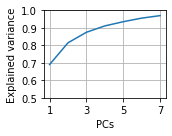

In [8]:
plt.plot(np.arange(latent_dim)+1,np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('PCs')
plt.ylabel('Explained variance')
plt.yticks(np.arange(0.5,1.01,.1))
plt.xticks(range(1,latent_dim+2,2))
plt.gcf().set_size_inches((2.5,2))
plt.grid()
plt.tight_layout()

### Gibbs sampling (AR-only)

  0%|          | 0/500 [00:00<?, ?it/s]

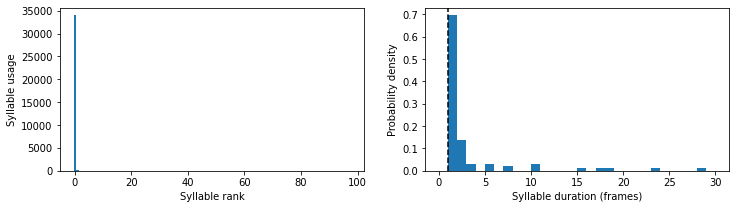

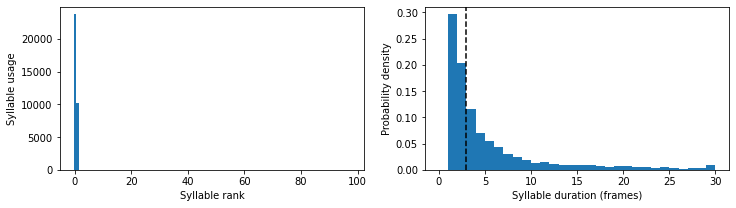

KeyboardInterrupt: 

In [9]:
num_iters = 500
plot_iters = 10
keys = jr.split(key,num_iters)

for i in tqdm.trange(num_iters):
    params['betas'],params['pi'] = resample_hdp_transitions(keys[i], **data, **states, **params, **trans_hypparams)
    params['Ab'],params['Q']= resample_ar_params(keys[i], **data, **states, **params, **ar_hypparams)
    states['z'],_ = resample_stateseqs(keys[i], **data, **states, **params)
    
    if i % plot_iters == 0:
        usage,durations = stateseq_stats(states['z'], mask)
        fig,axs = plt.subplots(1,2)
        axs[0].bar(range(len(usage)),sorted(usage, reverse=True))
        axs[0].set_ylabel('Syllable usage')
        axs[0].set_xlabel('Syllable rank')
        axs[1].hist(durations, range=(0,30), bins=30, density=True)
        axs[1].axvline(np.median(durations), linestyle='--', c='k')
        axs[1].set_xlabel('Syllable duration (frames)')
        axs[1].set_ylabel('Probability density')
        fig.set_size_inches((12,3))
        plt.show()

### Gibbs sampling (full model)

In [10]:
trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 100, 
    'kappa': 1e6/50,
    'num_states':num_states}

In [ ]:
num_iters = 500
plot_iters = 10
keys = jr.split(key,num_iters)

for i in tqdm.trange(num_iters):
    params['Ab'],params['Q'] = resample_ar_params(keys[i], **data, **states, **params, **ar_hypparams)
    params['sigmasq'] = resample_obs_variance(keys[i], **data, **states, **params, **obs_hypparams)
    params['betas'],params['pi'] = resample_hdp_transitions(keys[i], **data, **states, **params, **trans_hypparams)    
    states['z'] = resample_stateseqs(keys[i], **data, **states, **params)[0]
    states['x'] = resample_latents(keys[i], **data, **states, **params)
    states['h'] = resample_heading(keys[i], **data, **states, **params)
    states['v'] = resample_location(key, **data, **states, **params, **translation_hypparams)
    states['s'] = resample_scales(keys[i], **data, **states, **params, **obs_hypparams)
    
    if i % plot_iters == 0:
        usage,durations = stateseq_stats(states['z'], mask)
        fig,axs = plt.subplots(1,2)
        axs[0].bar(range(len(usage)),sorted(usage, reverse=True))
        axs[0].set_ylabel('Syllable usage')
        axs[0].set_xlabel('Syllable rank')
        axs[1].hist(durations, range=(0,30), bins=30, density=True)
        axs[1].axvline(np.median(durations), linestyle='--', c='k')
        axs[1].set_xlabel('Syllable duration (frames)')
        axs[1].set_ylabel('Probability density')
        fig.set_size_inches((8,2))
        plt.suptitle('Iteration {}, Median duration = {}'.format(i, np.median(durations)))
        plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]